*Use this notebook to complete the sentence similarity and embedding visualization tasks.*


In [21]:
import nltk
import numpy as np
import pickle
from gensim.models import KeyedVectors
import warnings
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text.lower())

def get_sentence_embedding(sentence, embedding_dict):
    """
    Get sentence embedding by averaging word embeddings.
    Only includes tokens that exist in the embedding dictionary.
    
    Args:
        sentence: Input sentence string
        embedding_dict: Dictionary mapping words to embedding vectors
    
    Returns:
        numpy array: Average embedding vector, or None if no valid tokens found
    """
    tokens = tokenize_text(sentence)
    # Only include tokens that exist in the vocabulary
    valid_embeddings = [embedding_dict[token] for token in tokens if token in embedding_dict]
    
    if len(valid_embeddings) == 0:
        warnings.warn(f"No valid tokens found in vocabulary for sentence: '{sentence}'")
        return None
    
    return np.mean(valid_embeddings, axis=0)

def get_sentence_similarity(sentence1, sentence2, embedding_dict):

    embedding1 = get_sentence_embedding(sentence1, embedding_dict)
    embedding2 = get_sentence_embedding(sentence2, embedding_dict)

    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    similarity = dot_product / (norm1 * norm2)
    return float(similarity)
    

[nltk_data] Downloading package punkt to /Users/n/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
# PyTorch Skip-Gram
with open('word2vec_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)
pytorch_embeddings = data['embeddings']
pytorch_word2idx = data['word2idx']
pytorch_idx2word = data['idx2word']
pytorch_emb_dict = {word: pytorch_embeddings[idx] for word, idx in pytorch_word2idx.items()}

# Gensim Word2Vec
with open('word2vec_gensim_embeddings.pkl', 'rb') as f:
    gensim_pickle_data = pickle.load(f)
gensim_embeddings_pickle = gensim_pickle_data['embeddings']
gensim_word2idx_pickle = gensim_pickle_data['word2idx']
gensim_idx2word_pickle = gensim_pickle_data['idx2word']
gensim_emb_dict = {word: gensim_embeddings_pickle[idx] for word, idx in gensim_word2idx_pickle.items()}

# Gensim Word2Vec Pretrained
pretrained_word2vec = KeyedVectors.load("word2vec-google-news-300.model")
pretrained_embeddings = pretrained_word2vec.vectors  # numpy array
pretrained_word2idx = {word: idx for idx, word in enumerate(pretrained_word2vec.index_to_key)}
pretrained_idx2word = pretrained_word2vec.index_to_key  # list
pretrained_emb_dict = {word: pretrained_word2vec[word] for word in pretrained_word2vec.index_to_key}

# Gensim FastText
fasttext_model = KeyedVectors.load("fasttext-wiki-news-subwords-300.model")
fasttext_embeddings = fasttext_model.vectors  # numpy array
fasttext_word2idx = {word: idx for idx, word in enumerate(fasttext_model.index_to_key)}
fasttext_idx2word = fasttext_model.index_to_key  # list
fasttext_emb_dict = {word: fasttext_model[word] for word in fasttext_model.index_to_key}



### Sentence Similarity

In [28]:
import pandas as pd

sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

# Query sentence
query = "My pet cat is sleeping on the carpet."


similarity_data = {
    'Sentence': sentences,
    'PyTorch Skip-Gram': [get_sentence_similarity(query, s, pytorch_emb_dict) for s in sentences],
    'Gensim Word2Vec': [get_sentence_similarity(query, s, gensim_emb_dict) for s in sentences],
    'Gensim Word2Vec Pretrained': [get_sentence_similarity(query, s, pretrained_emb_dict) for s in sentences],
    'Gensim FastText': [get_sentence_similarity(query, s, fasttext_emb_dict) for s in sentences]
}


similarity_df = pd.DataFrame(similarity_data)
# used ai to make this a table instead of my original code that just printed them
for col in similarity_df.columns[1:]:  # Skip the 'Sentence' column
    similarity_df[col] = similarity_df[col].apply(lambda x: f"{x:.4f}" if x is not None else "N/A")

display(similarity_df.style.set_caption(f"Query: '{query}'"))




,Sentence,PyTorch Skip-Gram,Gensim Word2Vec,Gensim Word2Vec Pretrained,Gensim FastText
0,The cat sat on the mat.,0.6599,0.6779,0.7369,0.9114
1,A dog is playing in the yard.,0.4549,0.5930,0.6483,0.8512
2,I need to buy groceries today.,0.4436,0.1872,0.3718,0.5858
3,The feline was resting on the rug.,0.1235,0.4835,0.7794,0.9247
4,Canines enjoy outdoor activities.,0.3932,0.0801,0.4281,0.6504
5,My shopping list includes milk and bread.,0.5757,0.4739,0.4970,0.8350
6,The weather is beautiful today.,0.3431,0.4943,0.4310,0.8090
7,Programming requires logical thinking.,0.4235,0.0539,0.2979,0.6135


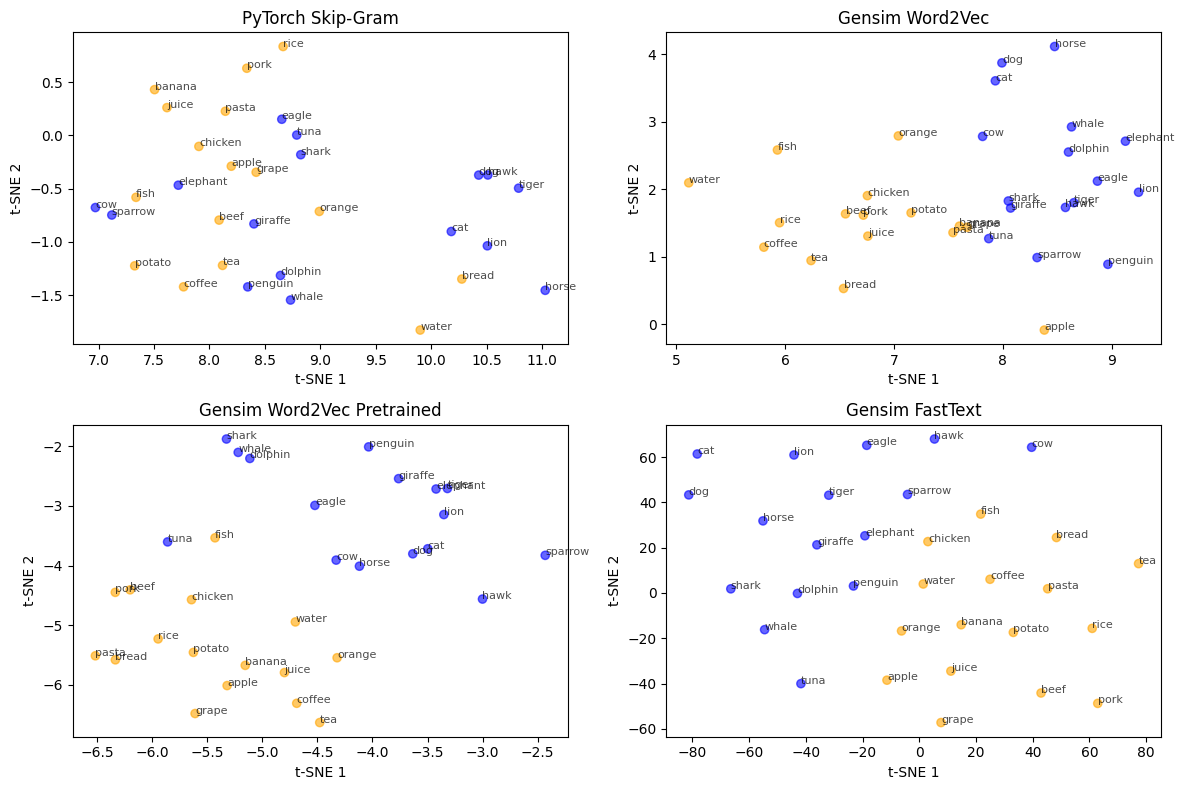

In [36]:
from sklearn.manifold import TSNE
import umap

animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]


words_to_plot = animals + foods

from matplotlib import pyplot as plt


model_data = [
    ('PyTorch Skip-Gram', pytorch_emb_dict, pytorch_word2idx),
    ('Gensim Word2Vec', gensim_emb_dict, gensim_word2idx_pickle),
    ('Gensim Word2Vec Pretrained', pretrained_emb_dict, pretrained_word2idx),
    ('Gensim FastText', fasttext_emb_dict, fasttext_word2idx)
]

plt.figure(figsize=(12, 8))

for i, (model_name, emb_dict, word2idx) in enumerate(model_data):
    plt.subplot(2, 2, i+1)
    valid_words = [word for word in words_to_plot if word in emb_dict]
    
    if len(valid_words) == 0:
        plt.text(0.5, 0.5, f'No words found in {model_name}', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(model_name)
        continue
    
    word_embeddings = np.array([emb_dict[word] for word in valid_words])
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(20, len(valid_words)-1))
    embeddings_2d = tsne.fit_transform(word_embeddings)
    
    colors = ['blue' if word in animals else 'orange' for word in valid_words]
    
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6)
    

    for j, word in enumerate(valid_words[::1]):
        plt.annotate(word, (embeddings_2d[j, 0], embeddings_2d[j, 1]), 
                    fontsize=8, alpha=0.7)
    
    plt.title(model_name)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
plt.tight_layout()
plt.show()




/Users/n/Documents/Northwestern/Year2/2_Winter/LLMs/stat359/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/n/Documents/Northwestern/Year2/2_Winter/LLMs/stat359/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/n/Documents/Northwestern/Year2/2_Winter/LLMs/stat359/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/n/Documents/Northwestern/Year2/2_Winter/LLMs/stat359/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/n/Documents/Northwestern/Year2/2_Winter/LLMs/stat35

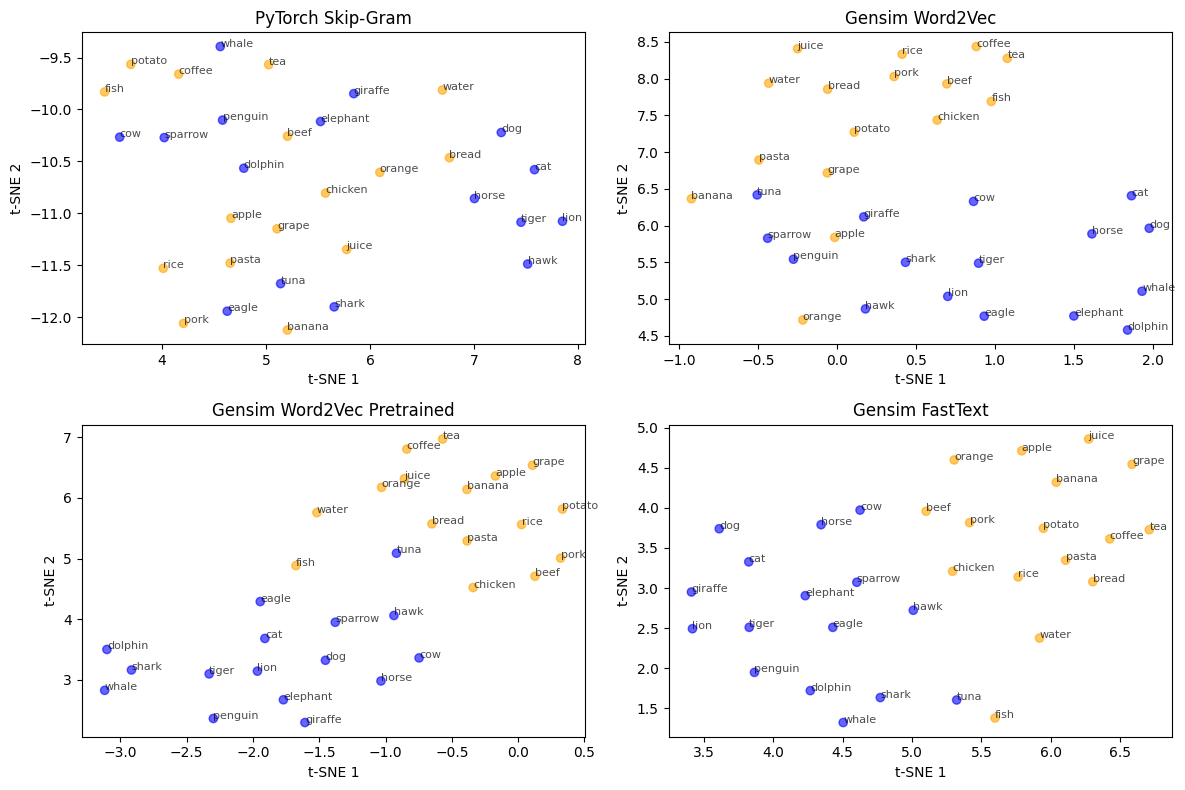

In [38]:
plt.figure(figsize=(12, 8))

for i, (model_name, emb_dict, word2idx) in enumerate(model_data):
    plt.subplot(2, 2, i+1)
    valid_words = [word for word in words_to_plot if word in emb_dict]
    
    if len(valid_words) == 0:
        plt.text(0.5, 0.5, f'No words found in {model_name}', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(model_name)
        continue
    
    word_embeddings = np.array([emb_dict[word] for word in valid_words])
    
    umap_model = umap.UMAP(n_components=2, random_state=42)
    embeddings_2d = umap_model.fit_transform(word_embeddings)
    
    colors = ['blue' if word in animals else 'orange' for word in valid_words]
    
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6)
    

    for j, word in enumerate(valid_words[::1]):
        plt.annotate(word, (embeddings_2d[j, 0], embeddings_2d[j, 1]), 
                    fontsize=8, alpha=0.7)
    
    plt.title(model_name)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
plt.tight_layout()
plt.show()

## Part 7: Short Answer Questions
The two pretrained models, Gensim Word2Vec and FastText, outperformed the pytorch and original Gensim api Word2Vec model in terms of capturing sentence meaning (as seen in the sentence embedding similarity) and word embedding (as seen in the t-SNE and UMAP visualization). The pretrained models show higher sentence similarity in the semantically identical sentences than the text8 models. The pretrained models also exhibit greater separation in the t-SNE and UMAP visualizations. The significantly better performance of these pretrained models is likely a result of their different/larger training corpus. There is also a clear improvement going from the Skip-Gram to the Word2Vec model even when both are trained on Text8. So, model architecture also plays a role.

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>

Cursor Auto

Used AI to create table and to help debug the code I wrote for visualizations. Also asked it whether my implementation of the pytorch training was correct, and implemented some suggestions it made there. 

I frequently reran code and did quick little tests, especially during the pytorch implementation. 
